# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [7]:
# Code Here
!pip install palmerpenguins
import pandas as pd
from palmerpenguins import load_penguins
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,accuracy_score,precision_recall_fscore_support,roc_auc_score,roc_curve)

In [2]:
penguins = load_penguins()

penguins = penguins.dropna()

y = penguins["species"]
X = penguins.drop(columns=["species"])
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [3]:
cat_vars = ["island", "sex"]
num_vars = [col for col in X.columns if col not in cat_vars]

In [4]:
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_vars),
    ("num", StandardScaler(), num_vars)
])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [6]:
# Code Here
knn3 = Pipeline([
    ("pre", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=3))
])

knn10 = Pipeline([
    ("pre", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=10))
])

tree3 = Pipeline([
    ("pre", preprocess),
    ("tree", DecisionTreeClassifier(max_depth=3, random_state=42))
])

tree6 = Pipeline([
    ("pre", preprocess),
    ("tree", DecisionTreeClassifier(max_depth=6, random_state=42))
])

models = {
    "kNN (3)": knn3,
    "kNN (10)": knn10,
    "Tree (depth=3)": tree3,
    "Tree (depth=6)": tree6
}

In [9]:
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nPrecision, Recall, F1:")
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)

    print("\nAUC (one-vs-rest):")
    for i, cls in enumerate(model.classes_):
        y_true_bin = (y_test == cls).astype(int)
        print(cls, ":", roc_auc_score(y_true_bin, y_prob[:, i]))



In [10]:
print("kNN (k=3)")
evaluate(knn3, X_train, X_test, y_train, y_test)

print("\nkNN (k=10)")
evaluate(knn10, X_train, X_test, y_train, y_test)

print("\nDecision Tree (depth=3)")
evaluate(tree3, X_train, X_test, y_train, y_test)

print("\nDecision Tree (depth=6)")
evaluate(tree6, X_train, X_test, y_train, y_test)


kNN (k=3)
Accuracy: 0.9761904761904762

Confusion Matrix:
[[36  1  0]
 [ 1 16  0]
 [ 0  0 30]]

Precision, Recall, F1:
Precision: [0.97297297 0.94117647 1.        ]
Recall: [0.97297297 0.94117647 1.        ]
F1: [0.97297297 0.94117647 1.        ]

AUC (one-vs-rest):
Adelie : 0.9994249568717654
Chinstrap : 0.9991220368744512
Gentoo : 1.0

kNN (k=10)
Accuracy: 1.0

Confusion Matrix:
[[37  0  0]
 [ 0 17  0]
 [ 0  0 30]]

Precision, Recall, F1:
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1: [1. 1. 1.]

AUC (one-vs-rest):
Adelie : 1.0
Chinstrap : 1.0
Gentoo : 1.0

Decision Tree (depth=3)
Accuracy: 0.9642857142857143

Confusion Matrix:
[[37  0  0]
 [ 1 16  0]
 [ 2  0 28]]

Precision, Recall, F1:
Precision: [0.925 1.    1.   ]
Recall: [1.         0.94117647 0.93333333]
F1: [0.96103896 0.96969697 0.96551724]

AUC (one-vs-rest):
Adelie : 0.957159286946521
Chinstrap : 0.9986830553116769
Gentoo : 0.9666666666666667

Decision Tree (depth=6)
Accuracy: 0.9761904761904762

Confusion Matrix:
[[37  0  0]

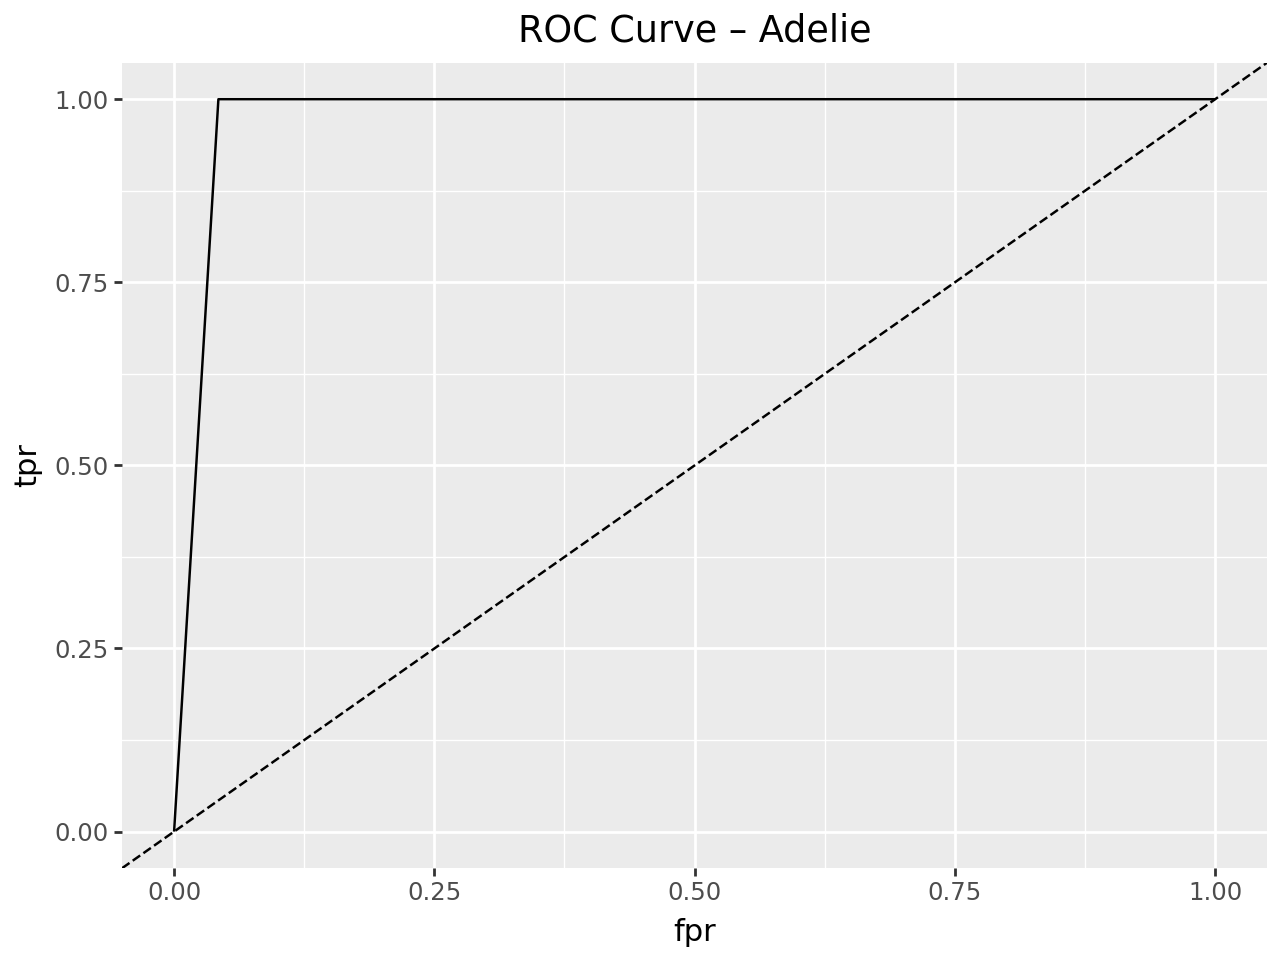

In [12]:
model = tree6
species = "Adelie"

model.fit(X_train, y_train)

i = list(model.classes_).index(species)
y_score = model.predict_proba(X_test)[:, i]
y_true = (y_test == species).astype(int)

fpr, tpr, _ = roc_curve(y_true, y_score)

df = pd.DataFrame({"fpr": fpr, "tpr": tpr})

(
    ggplot(df, aes("fpr", "tpr"))
    + geom_line()
    + geom_abline(linetype="dashed")
    + labs(title=f"ROC Curve – {species}")
)
